# Reviewing ECMWF hindcasts 

## Check for possibility of a readiness trigger with a longer lead time

The current forecast (Meteo France La Reunion) provides limited lead time and we should explore if we could use ECMWF to have a readiness signal. I would basically check some basic perfomance metrics vs lead time and decide with partners what is acceptable.

In [ ]:
%load_ext jupyter_black

import os
from datetime import datetime
from pathlib import Path
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import glob
from shapely.geometry import Point
from datetime import timedelta
from src.constants import *
from src.utils import *
from src.datasources import rsmc, helpers

In [2]:
import warnings

warnings.filterwarnings("ignore")

In [ ]:
save_dir = (
    Path(AA_DATA_DIR) / "public" / "exploration" / "moz" / "ecmwf_hindcast"
)
ADMS = ["Sofala", "Inhambane", "Nampula", "Zambezia"]
adm1_path = (
    Path(AA_DATA_DIR)
    / "public"
    / "raw"
    / "moz"
    / "cod_ab"
    / "moz_admbnda_adm1_ine_20190607.shp"
)
gdf_adm1 = gpd.read_file(adm1_path)
gdf_sel = gdf_adm1[gdf_adm1.ADM1_PT.isin(ADMS)]
ibtracs_path = adm1_path = (
    Path(AA_DATA_DIR) / "public" / "raw" / "glb" / "ibtracs"
)
points_path = Path(
    ibtracs_path
    / "IBTrACS.SI.list.v04r01.points/IBTrACS.SI.list.v04r01.points.shp"
)
gdf_points = gpd.read_file(points_path)
gdf_points["Date"] = [
    datetime.strptime(dt, "%Y-%m-%d %H:%M:%S").date()
    for dt in gdf_points["ISO_TIME"]
]

In [5]:
categories = [name for name, order in category_order.items() if order >= 4]

In [ ]:
gdf_points["REU_USA_WIND"] = gdf_points["REU_WIND"].fillna(
    gdf_points["USA_WIND"] * MIN1_TO_MIN10
)

In [ ]:
# testing for cyclone Freddy
gdf_points["ISO_TIME"] = pd.to_datetime(gdf_points["ISO_TIME"])
gdf_points_cyclone = gdf_points[gdf_points["NAME"] == "FREDDY"]
cyclone_file = pd.read_csv(save_dir / f"csv/freddy_all.csv")
cyclone_file["time"] = pd.to_datetime(cyclone_file["time"])
cyclone_df = (
    cyclone_file[["time", "speed", "lat", "lon", "lead_time", "forecast_time"]]
    .groupby(["time", "forecast_time"])
    .median()
    .reset_index()
)
df = pd.merge(
    gdf_points_cyclone,
    cyclone_df,
    left_on="ISO_TIME",
    right_on="time",
    how="inner",
)
df["speed_knots"] = df["speed"] * MPS2KTS
# Apply the function to create a new column "storm_category"
df["actual_storm_category"] = df["REU_USA_WIND"].apply(categorize_cyclone)
df["forecasted_storm_category"] = df["speed_knots"].apply(categorize_cyclone)

In [8]:
df[
    [
        "lead_time",
        "actual_storm_category",
        "forecasted_storm_category",
        "LAT",
        "LON",
        "lat",
        "lon",
    ]
][df["REU_USA_WIND"] > 34]

,lead_time,actual_storm_category,forecasted_storm_category,LAT,LON,lat,lon
20,48.0,Moderate Tropical Storm,Tropical Depression,-22.5,39.6,-21.8,39.9
21,36.0,Moderate Tropical Storm,Tropical Depression,-22.5,39.6,-21.8,40.2
22,24.0,Moderate Tropical Storm,Tropical Depression,-22.5,39.6,-21.8,39.6
23,12.0,Moderate Tropical Storm,Tropical Depression,-22.5,39.6,-22.1,40.1
24,0.0,Moderate Tropical Storm,Moderate Tropical Storm,-22.5,39.6,-22.5,40.3
...,...,...,...,...,...,...,...
477,48.0,Moderate Tropical Storm,Moderate Tropical Storm,-17.0,35.2,-17.1,35.4
478,36.0,Moderate Tropical Storm,Tropical Depression,-17.0,35.2,-16.7,35.2
479,24.0,Moderate Tropical Storm,Tropical Depression,-17.0,35.2,-16.5,35.4
480,12.0,Moderate Tropical Storm,Tropical Depression,-17.0,35.2,-16.7,35.2


### Checking how long it would take to make landfall after crossing certain longitudes

In [9]:
moz_cyclones = [
    Path(f).stem.replace("_all", "").upper()
    for f in glob.glob(str(Path(save_dir) / "csv" / "*_all.csv"))
]

In [10]:
def compute_average_landfall_time_per_longitude(
    gdf_points, lon_start, lon_end, gdf_sel, moz_cyclones
):
    lon_range = range(lon_start, lon_end + 1)
    avg_landfall_times = []

    for lon in lon_range:
        landfall_times = []

        for cyclone_name in moz_cyclones:
            gdf_points_yr = gdf_points[gdf_points["year"] >= 1980]
            cyclone_gdf = gdf_points_yr[gdf_points_yr["NAME"] == cyclone_name]

            if cyclone_gdf.empty:
                continue

            # Convert ISO_TIME to datetime
            cyclone_gdf["ISO_TIME"] = pd.to_datetime(cyclone_gdf["ISO_TIME"])

            if cyclone_gdf.empty:
                continue

            cyclone_gdf = cyclone_gdf.sort_values(by="ISO_TIME")

            crossing_time = None
            landfall_time = None

            # Identify crossing of the longitude
            for _, row in cyclone_gdf.iterrows():
                if row["LON"] <= lon and crossing_time is None:
                    crossing_time = row["ISO_TIME"]

                # Remove data points after crossing
                if crossing_time and row["LON"] > lon:
                    break

            if crossing_time:
                # Check if cyclone made landfall within gdf_sel
                for _, row in cyclone_gdf.iterrows():
                    point = Point(row["LON"], row["LAT"])
                    if gdf_sel.contains(point).any():
                        landfall_time = row["ISO_TIME"]
                        break

                if landfall_time:
                    time_to_landfall = (
                        landfall_time - crossing_time
                    ).total_seconds() / 3600  # in hours
                    landfall_times.append(time_to_landfall)

        if landfall_times:
            average_landfall_time = np.mean(landfall_times)
            avg_landfall_times.append((lon, average_landfall_time))
        else:
            avg_landfall_times.append(
                (lon, np.nan)
            )  # No data for this longitude

    return avg_landfall_times


# Define longitude range
lon_start = 35
lon_end = 50

# Compute average landfall times
avg_landfall_times = compute_average_landfall_time_per_longitude(
    gdf_points, lon_start, lon_end, gdf_sel, moz_cyclones
)

# Convert results to DataFrame for easier plotting
df_results = pd.DataFrame(
    avg_landfall_times, columns=["Longitude", "Average_Time_to_Landfall"]
)

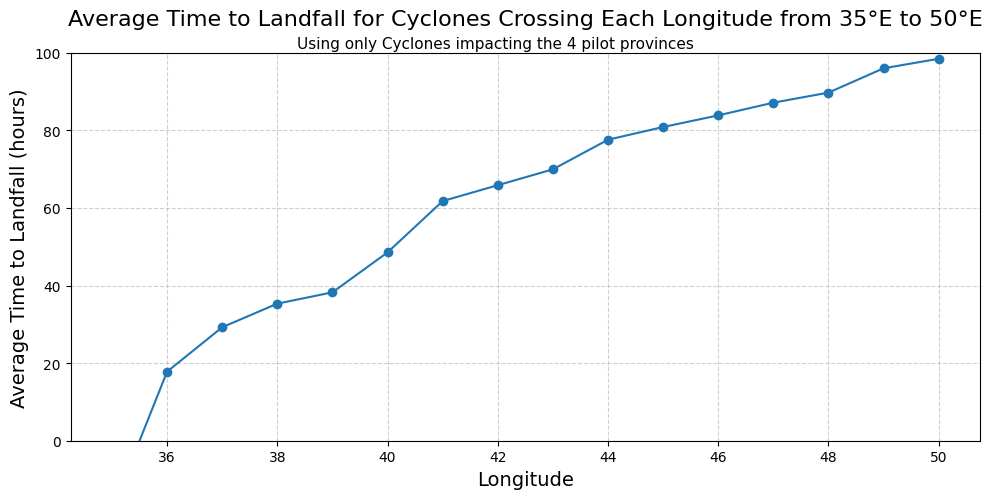

In [11]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(
    df_results["Longitude"], df_results["Average_Time_to_Landfall"], marker="o"
)
plt.xlabel("Longitude", fontsize=14)
plt.ylabel("Average Time to Landfall (hours)", fontsize=14)
plt.ylim(0, 100)
plt.title(
    "Average Time to Landfall for Cyclones Crossing Each Longitude from 35°E to 50°E",
    fontsize=16,
    pad=20,  # Adds space between title and plot
)
plt.suptitle(
    "Using only Cyclones impacting the 4 pilot provinces",
    fontsize=11,  # Subtitle font size
    y=0.78,  # Adjust subtitle position; should be slightly below the title
)
plt.grid(True, linestyle="--", alpha=0.6)

# Adjust layout to fit title and subtitle
plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()

### Getting the location error in km

### Getting the location error over all points on land

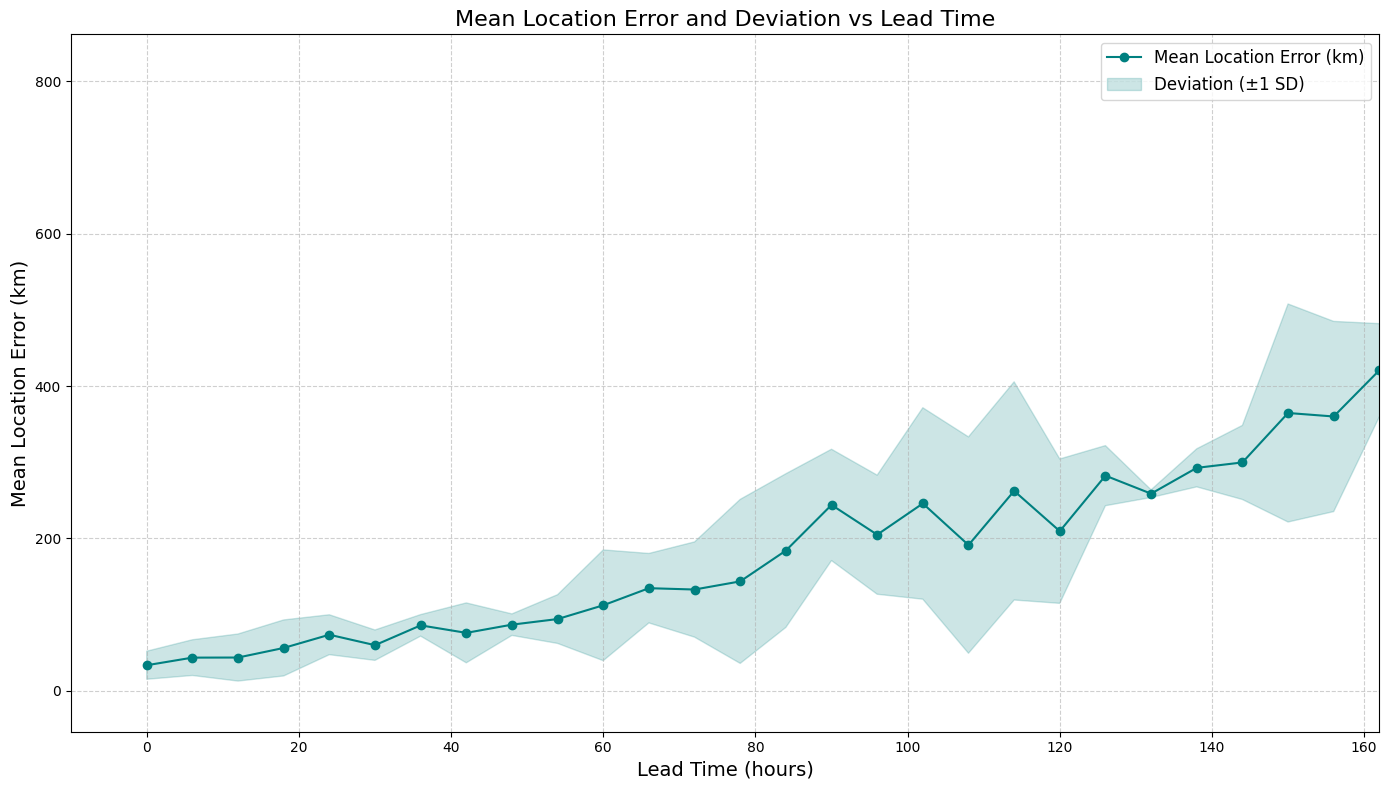

In [ ]:
combined_metrics = helpers.compute_location_error_metrics(
    gdf_points=gdf_points,
    save_dir=save_dir,
    gdf_sel=gdf_sel,
    storm_categories=None,  # List of categories to filter by
)
combined_metrics = combined_metrics.groupby("lead_time").mean().reset_index()
# Create a line plot with deviation
plt.figure(figsize=(14, 8))

# Plot the mean location error as a line
plt.plot(
    combined_metrics["lead_time"],
    combined_metrics["mean_location_error_km"],
    color="teal",
    marker="o",
    linestyle="-",
    label="Mean Location Error (km)",
)

# Fill the area between the mean ± standard deviation
plt.fill_between(
    combined_metrics["lead_time"],
    combined_metrics["mean_location_error_km"]
    - combined_metrics["std_location_error_km"],
    combined_metrics["mean_location_error_km"]
    + combined_metrics["std_location_error_km"],
    color="teal",
    alpha=0.2,
    label="Deviation (±1 SD)",
)

# Add plot details
plt.xlabel("Lead Time (hours)", fontsize=14)
plt.ylabel("Mean Location Error (km)", fontsize=14)
plt.title("Mean Location Error and Deviation vs Lead Time", fontsize=16)
plt.legend(loc="best", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.xlim(-10, 162)
# Display the plot
plt.tight_layout()
plt.show()

### Location error only for landfall location

### Landfall Location distance from forecast

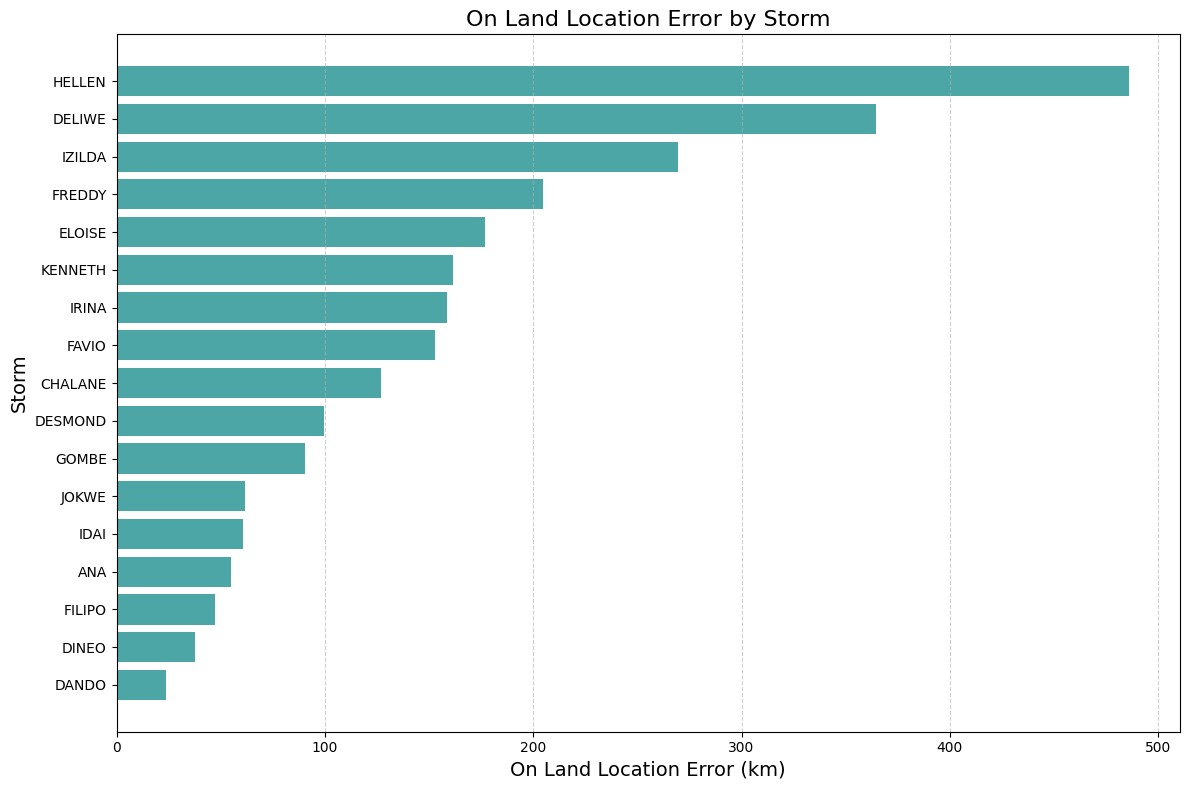

In [ ]:

combined_metrics = helpers.compute_location_error_metrics_by_category(
    gdf_points=gdf_points,
    save_dir=save_dir,
    gdf_sel=gdf_sel,
    storm_categories=None,  # List of categories to filter by
)

combined_metrics_sorted = combined_metrics.sort_values(
    by="location_error_km", ascending=True
)

# Create a horizontal bar plot
plt.figure(figsize=(12, 8))
plt.barh(
    combined_metrics_sorted["NAME"],
    combined_metrics_sorted["location_error_km"],
    color="teal",
    alpha=0.7,
)

# Add plot details
plt.xlabel("On Land Location Error (km)", fontsize=14)
plt.ylabel("Storm", fontsize=14)
plt.title("On Land Location Error by Storm", fontsize=16)
plt.grid(axis="x", linestyle="--", alpha=0.6)

# Display the plot
plt.tight_layout()
plt.show()

### How close to the landfall location is the forecast?

In [355]:
# Function to compute the location error metrics
# Initialize lists to store metrics
all_metrics = []

# Iterate over all cyclone files
for cyclone_file_path in glob.glob(str(save_dir / "csv/*_all.csv")):
    cyclone_name = Path(cyclone_file_path).stem.split("_")[0]

    gdf_points_cyclone = gdf_points[gdf_points["NAME"] == cyclone_name.upper()]
    gdf_points_cyclone["ISO_TIME"] = pd.to_datetime(gdf_points_cyclone["ISO_TIME"])

    cyclone_file = pd.read_csv(cyclone_file_path)
    cyclone_file["time"] = pd.to_datetime(cyclone_file["time"])

    cyclone_df = (
        cyclone_file[["time", "speed", "lat", "lon", "lead_time", "forecast_time"]]
        .groupby(["time", "forecast_time"])
        .median()
        .reset_index()
    )
    cyclone_df["lat"] = cyclone_df["lat"].apply(lambda x: -x if x > 0 else x)

    df = pd.merge(
        gdf_points_cyclone,
        cyclone_df,
        left_on="ISO_TIME",
        right_on="time",
        how="outer",
    )

    # Check if actual points are within the region
    df["actual_within_region"] = df.apply(
        lambda row: is_within_region(row["LAT"], row["LON"], gdf_sel),
        axis=1,
    )

    # Check if forecasted location is within the region
    df["forecast_within_region"] = df.apply(
        lambda row: is_within_region(row["lat"], row["lon"], gdf_sel),
        axis=1,
    )

    actual_landfall = df[df["actual_within_region"]]["ISO_TIME"].min()
    if pd.isnull(actual_landfall):
        continue
    errors = []

    for lt, lt_df in df.groupby("forecast_time"):
        forecast_landfall = lt_df[lt_df["forecast_within_region"]]["time"].min()
        if pd.isnull(forecast_landfall):
            continue
        if not pd.isnull(forecast_landfall):
            actual_lon = df[df["ISO_TIME"] == actual_landfall]["LON"].min()
            actual_lat = df[df["ISO_TIME"] == actual_landfall]["LAT"].min()
            forecast_lon = df[df["time"] == forecast_landfall]["lon"].min()
            forecast_lat = df[df["time"] == forecast_landfall]["lat"].min()

            lt_df["landfall_error_km"] = lt_df.apply(
                lambda row: haversine(
                    actual_lon, actual_lat, forecast_lon, forecast_lat
                ),
                axis=1,
            )

            # Append relevant data to errors list
            for _, row in lt_df.iterrows():
                errors.append(
                    {
                        "lead_time": row["lead_time"],
                        "landfall_error_km": row["landfall_error_km"],
                    }
                )
    if len(errors) > 0:
        # Convert errors list to DataFrame
        errors_df = pd.DataFrame(errors)
        errors_df = errors_df.groupby("lead_time").mean().reset_index()

    all_metrics.append(errors_df)

# Combine all metrics
combined_metrics = pd.concat(all_metrics)

### Getting the location error by checking if it will make landfall within the 4 provinces

### For all lead times

In [ ]:

combined_metrics = helpers.compute_within_region_metrics(gdf_points, save_dir, gdf_sel)

# Plotting the results
plt.figure(figsize=(14, 8))

# Line plot for mean percentages
plt.plot(
    combined_metrics["lead_time"],
    combined_metrics["percentage_correct_positive"],
    color="green",
    linestyle="-",
    linewidth=2,
    label="Correctly Forecasted Inside Region (%)",
)

plt.plot(
    combined_metrics["lead_time"],
    combined_metrics["percentage_false_positive"],
    color="red",
    linestyle="-",
    linewidth=2,
    label="Incorrectly Forecasted Inside Region (%)",
)

plt.plot(
    combined_metrics["lead_time"],
    combined_metrics["percentage_false_negative"],
    color="orange",
    linestyle="-",
    linewidth=2,
    label="Incorrectly Forecasted Outside Region (%)",
)

plt.plot(
    combined_metrics["lead_time"],
    combined_metrics["percentage_correct_negative"],
    color="blue",
    linestyle="-",
    linewidth=2,
    label="Correctly Forecasted Outside Region (%)",
)

# Add plot details
plt.xlabel("Lead Time (hours)", fontsize=14)
plt.ylabel("Percentage (%)", fontsize=14)
plt.title(
    "Percentages of Correct and Incorrect Forecasts Within the 4 Pilot Provinces vs Lead Time",
    fontsize=16,
)
plt.legend(loc="best", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)

# Display the plot
plt.tight_layout()
plt.show()

### For the 4 provinces


In [ ]:
combined_metrics = helpers.compute_within_region_metrics(gdf_points, save_dir, gdf_sel)

# Plotting the results
provinces = combined_metrics["province"].unique()

fig, axs = plt.subplots(2, 2, figsize=(18, 10), sharex=True, sharey=True)
fig.suptitle(
    "Percentages of Correct and Incorrect Forecasts Within Each Province vs Lead Time",
    fontsize=16,
)
colors = ["green", "red", "orange", "blue"]

for i, province in enumerate(provinces):
    ax = axs[i // 2, i % 2]
    province_data = combined_metrics[combined_metrics["province"] == province]

    ax.plot(
        province_data["lead_time"],
        province_data["percentage_correct_positive"],
        color="green",
        linestyle="-",
        linewidth=2,
        label="Correctly Forecasted Inside (%)",
    )
    ax.plot(
        province_data["lead_time"],
        province_data["percentage_false_positive"],
        color="red",
        linestyle="-",
        linewidth=2,
        label="Incorrectly Forecasted Inside (%)",
    )
    ax.plot(
        province_data["lead_time"],
        province_data["percentage_false_negative"],
        color="orange",
        linestyle="-",
        linewidth=2,
        label="Incorrectly Forecasted Outside (%)",
    )
    ax.plot(
        province_data["lead_time"],
        province_data["percentage_correct_negative"],
        color="blue",
        linestyle="-",
        linewidth=2,
        label="Correctly Forecasted Outside (%)",
    )

    ax.set_title(province)
    ax.set_xlabel("Lead Time (hours)", fontsize=12)
    ax.set_ylabel("Percentage (%)", fontsize=12)
    ax.grid(True, linestyle="--", alpha=0.6)
    ax.legend(loc="best", fontsize=10)

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()